In [10]:
import numpy as np
import os
import random
import tensorflow as tf
from CNN.utility import train_routine
from ds_creation.ds_utility import get_file_count, get_other_class
from ds_creation.split_config import phisical_split
from ds_creation.plot_utility import process_metrics



SPLIT_PERC = {'train': 0.8, 'val': 0.2}
TEST_SPLIT = 0.2

DATA_DIR = os.path.join('data', 'mammals_calls', 'data')
TEST_DIR = os.path.join('data', 'mammals_calls_test', 'data')
SPLIT_DIR = os.path.join('data', 'mammals_calls', 'splits', 'custom')
AUDIO_DIR = os.path.join('data', 'audio')
MODELS_METRICS_DIR = os.path.join("models_metrics")
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")

PATIENCE = 5
TO_TRAIN = True
FROM_START = True
os.makedirs(MODELS_METRICS_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
    
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Eseguo lo split fisico dei file solo la prima volta per dividere i file in train e test
FIRST_RUN = False
if FIRST_RUN:
    perc = 1-TEST_SPLIT
    phisical_split(DATA_DIR, perc)


Vengono divise le specie in tre gruppi:
* Quelle per il training della CNN, hanno più di 1000 sample, le restanti classi formeranno la classe other
* Quelle per il training della Prototypical, hanno tra i 1000 ed i 100 sample
* Quelle per il test della Prototypical, hanno meno di 100 sample 

Così vengono creati i file che serviranno alla prototypical per splittare le classi tra train, validation e test

In [2]:
count_df = get_file_count(DATA_DIR)

CNN_training = count_df[count_df['file_count'] >= 1000]['species'].tolist()
proto_training = count_df[(count_df['file_count'] <= 1000) & (count_df['file_count'] >= 100)]['species'].tolist()
proto_test = count_df[count_df['file_count'] < 100]['species'].tolist()

random.shuffle(proto_training)
split_idx = int(len(proto_training) * SPLIT_PERC['train'])
proto_train = proto_training[:split_idx]
proto_val = proto_training[split_idx:]

with open(os.path.join(SPLIT_DIR, 'test.txt'), 'w') as f:
    for species in proto_test:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'train.txt'), 'w') as f:
    for species in proto_train:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'val.txt'), 'w') as f:
    for species in proto_val:
        f.write(f"{species}\n")



Viene fisicamente generata la classe other, contenente i files di tutte le altre classi che hanno meno di 1000 sample.
Viene quindi avviato il training della CNN su queste classi con uno split train/val 80/20 per stabilire il numero di epoche ottimale per l'addestramento.

In [3]:
count_df_truncated = get_file_count(DATA_DIR)
count_df_truncated = count_df_truncated[count_df_truncated['file_count'] < 999]

other_species_list = count_df_truncated['species'].tolist()
print(f'Other total files: {count_df_truncated["file_count"].sum()}, species count: {count_df_truncated.shape}, species: {other_species_list}')
get_other_class(DATA_DIR, other_species_list)

count_df = get_file_count(DATA_DIR)

Other total files: 6000, species count: (39, 2), species: ['Common_Dolphin', 'White-sided_Dolphin', 'Walrus', 'Clymene_Dolphin', "Fraser's_Dolphin", 'False_Killer_Whale', 'Striped_Dolphin', 'West_Indian_Manatee', 'Ross_Seal', 'Northern_Right_Whale', "Grampus,_Risso's_Dolphin", 'Harbor_Porpoise', 'Minke_Whale', 'Atlantic_Spotted_Dolphin', 'Dusky_Dolphin', 'Long_Beaked_(Pacific)_Common_Dolphin', 'Leopard_Seal', 'Beluga,_White_Whale', 'Melon_Headed_Whale', 'White-beaked_Dolphin', 'Gray_Whale', 'Harp_Seal', 'Southern_Right_Whale', 'Boutu,_Amazon_River_Dolphin', 'Ribbon_Seal', "Heaviside's_Dolphin", "Dall's_Porpoise", 'Rough-Toothed_Dolphin', 'Spotted_Seal', 'Irawaddy_Dolphin', 'Narwhal', 'Ringed_Seal', 'Juan_Fernandez_Fur_Seal', 'Tucuxi_Dolphin', 'Hooded_Seal', 'Sea_Otter', 'Finless_Porpoise', 'Steller_Sea_Lion', 'New_Zealand_Fur_Seal']


In [5]:
other_ds, history = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), cardinality=1000, subfolder='14-10_training', from_start=FROM_START, to_train=True)

Total classes found: 13
Found 70114 files belonging to 13 classes.
Using 56092 files for training.
Found 70114 files belonging to 13 classes.
Using 14022 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 397, 164, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
training
Epoch 1/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5938 - loss: 0.9995 - total: 28055.9980 - tp_hm: 18412.2383

2025-10-14 11:55:47.882748: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 111s 30ms/step - accuracy: 0.7170 - loss: 0.6505 - total: 56092.0000 - tp_hm: 40218.0000 - val_accuracy: 0.5390 - val_loss: 1.2603 - val_total: 14022.0000 - val_tp_hm: 7558.0000 - val_confusion_matrix: 82.9704
Epoch 2/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.8515 - loss: 0.3237 - total: 56092.0000 - tp_hm: 47764.0000 - val_accuracy: 0.8538 - val_loss: 0.4182 - val_total: 14022.0000 - val_tp_hm: 11972.0000 - val_confusion_matrix: 82.9704
Epoch 3/50
   4/3506 ━━━━━━━━━━━━━━━━━━━━ 1:07 19ms/step - accuracy: 0.9831 - loss: 0.0909 - total: 40.0000 - tp_hm: 39.0000

2025-10-14 11:57:23.474826: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.8797 - loss: 0.2579 - total: 56092.0000 - tp_hm: 49345.0000 - val_accuracy: 0.9084 - val_loss: 0.2633 - val_total: 14022.0000 - val_tp_hm: 12738.0000 - val_confusion_matrix: 82.9704
Epoch 4/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.8955 - loss: 0.2275 - total: 56092.0000 - tp_hm: 50230.0000 - val_accuracy: 0.9094 - val_loss: 0.2683 - val_total: 14022.0000 - val_tp_hm: 12752.0000 - val_confusion_matrix: 82.9704
Epoch 5/50
   4/3506 ━━━━━━━━━━━━━━━━━━━━ 1:10 20ms/step - accuracy: 0.8190 - loss: 0.3373 - total: 40.0000 - tp_hm: 34.0000

2025-10-14 12:00:33.463122: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9028 - loss: 0.2116 - total: 56092.0000 - tp_hm: 50642.0000 - val_accuracy: 0.8561 - val_loss: 0.3863 - val_total: 14022.0000 - val_tp_hm: 12004.0000 - val_confusion_matrix: 82.9704
Epoch 6/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9080 - loss: 0.1930 - total: 56092.0000 - tp_hm: 50932.0000 - val_accuracy: 0.6866 - val_loss: 0.8326 - val_total: 14022.0000 - val_tp_hm: 9628.0000 - val_confusion_matrix: 82.9704
Epoch 7/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9126 - loss: 0.1868 - total: 56092.0000 - tp_hm: 51191.0000 - val_accuracy: 0.9131 - val_loss: 0.2350 - val_total: 14022.0000 - val_tp_hm: 12804.0000 - val_confusion_matrix: 82.9704
Epoch 8/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9153 - loss: 0.1821 - total: 56092.0000 - tp_hm: 51340.0000 - val_accuracy: 0.9162 - val_loss: 0.2233 - val_total: 14022.0000 - val_tp_hm: 12847.0000 - val_confusion_matrix: 82.9704
Epoc

2025-10-14 12:06:53.057623: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9189 - loss: 0.1747 - total: 56092.0000 - tp_hm: 51542.0000 - val_accuracy: 0.8889 - val_loss: 0.3037 - val_total: 14022.0000 - val_tp_hm: 12464.0000 - val_confusion_matrix: 82.9704
Epoch 10/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9211 - loss: 0.1676 - total: 56092.0000 - tp_hm: 51664.0000 - val_accuracy: 0.9040 - val_loss: 0.2624 - val_total: 14022.0000 - val_tp_hm: 12676.0000 - val_confusion_matrix: 82.9704
Epoch 11/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9224 - loss: 0.1661 - total: 56092.0000 - tp_hm: 51739.0000 - val_accuracy: 0.6858 - val_loss: 0.8451 - val_total: 14022.0000 - val_tp_hm: 9616.0000 - val_confusion_matrix: 82.9704
Epoch 12/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9231 - loss: 0.1636 - total: 56092.0000 - tp_hm: 51780.0000 - val_accuracy: 0.9078 - val_loss: 0.2541 - val_total: 14022.0000 - val_tp_hm: 12729.0000 - val_confusion_matrix: 82.9704
E

{'accuracy': [0.7170006632804871, 0.8515296578407288, 0.8797154426574707, 0.8954930901527405, 0.9028381705284119, 0.9080082774162292, 0.9126256704330444, 0.9152820110321045, 0.9188832640647888, 0.9210582375526428, 0.9223953485488892, 0.9231262803077698, 0.9234650135040283], 'loss': [0.6505193114280701, 0.32368066906929016, 0.25794360041618347, 0.22750885784626007, 0.21163085103034973, 0.1929592788219452, 0.186769038438797, 0.1821451485157013, 0.174732506275177, 0.16764062643051147, 0.16605521738529205, 0.16359321773052216, 0.16370607912540436], 'total': [56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0], 'tp_hm': [40218.0, 47764.0, 49345.0, 50230.0, 50642.0, 50932.0, 51191.0, 51340.0, 51542.0, 51664.0, 51739.0, 51780.0, 51799.0], 'val_accuracy': [0.5390101075172424, 0.8538011908531189, 0.9084296226501465, 0.909428060054779, 0.8560832738876343, 0.6866353154182434, 0.9131364822387695, 0.9162030816078186, 0.888888895511627

In [9]:
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print(f'Best epoch: {best_epoch}, val_accuracy: {history.history["val_accuracy"][best_epoch-1]}, accuracy: {history.history["accuracy"][best_epoch-1]}')

Best epoch: 8, val_accuracy: 0.9162030816078186, accuracy: 0.9152820110321045


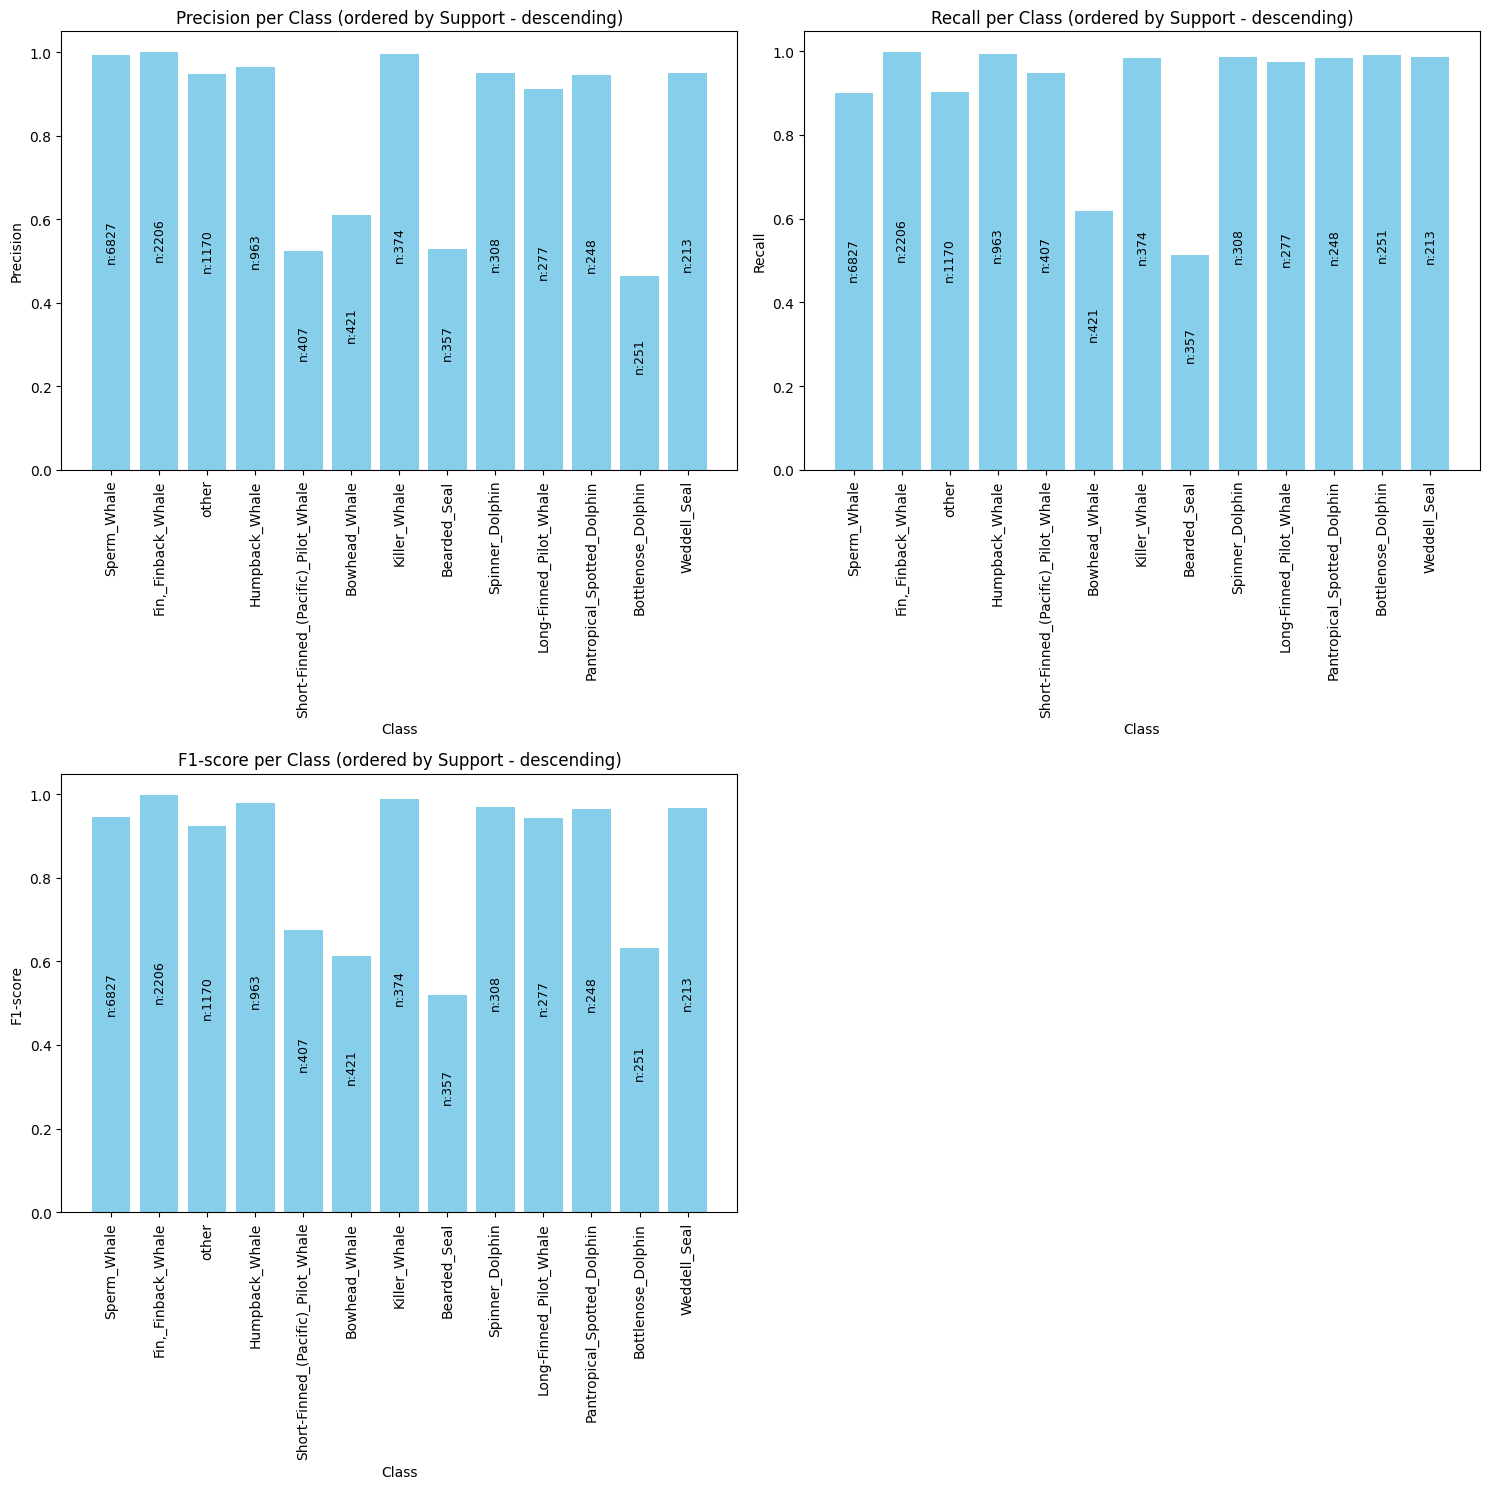

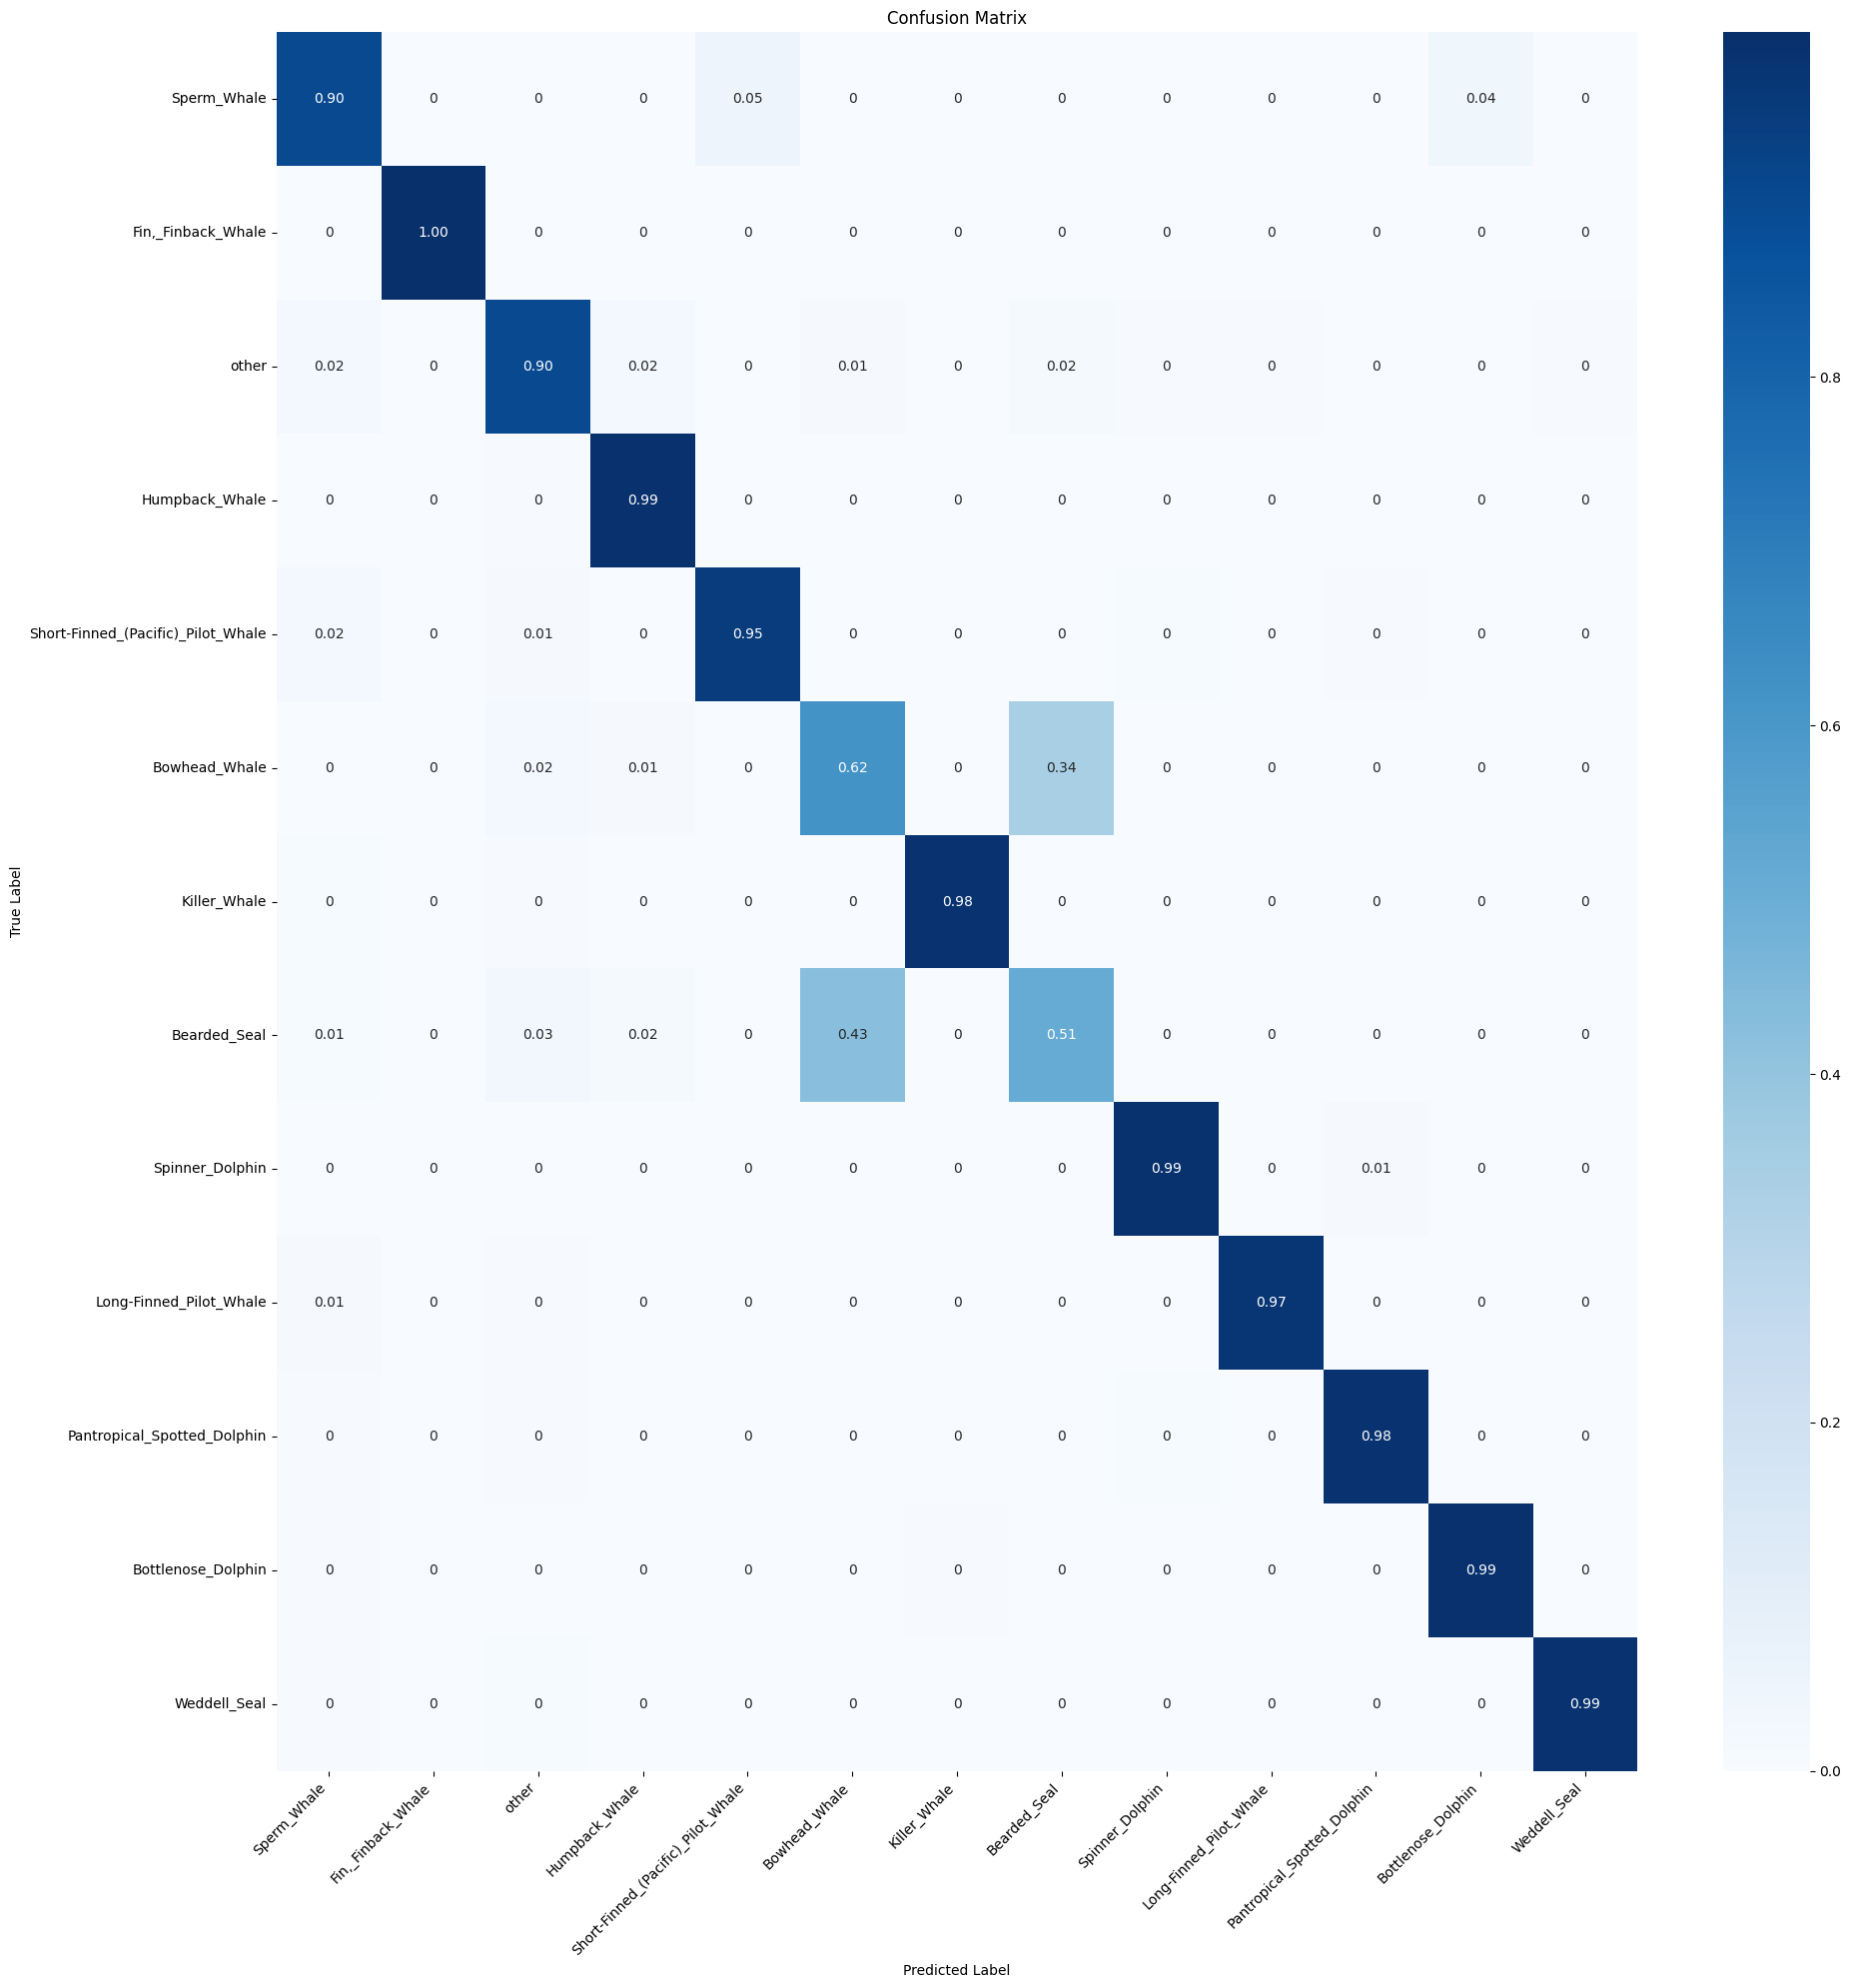

FileNotFoundError: [Errno 2] No such file or directory: 'models_metrics/tsne_data.csv'

In [ ]:
curr_training_date = '13-10'
process_metrics(count_df, 13, os.path.join(MODELS_METRICS_DIR, f'{curr_training_date}_training'), MODELS_METRICS_DIR)